# Name classification with recurrent neural networks

## Introduction

**In this notebook, we train a recurrent neural network to categorize last names. We train the network on lists of names for 15 countries. For a given new name, the trained network then assigns the country it most associates that name with.**

The present notebook is based on this tutorial https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html; in particular we have the same goal: name classification using recurrent neural networks.

There are many small differences between the present notebook and the tutorial, but also some relatively big differences:


* **We use different data for the last names.** The reason is that in the dataset used in the tutorial, the number of names in each language is far from uniform (e.g. there are over 10000 Russian names, but less than 200 Vietnamese names). We use a more balanced dataset, by taking the most popular last names from various countries from the NameDataset (https://github.com/philipperemy/name-dataset; this package needs to be installed to successfully run the present notebook).
* **We use a different neural network.** In the tutorial, a linear neural network is used. We add hidden layers with nonlinear ReLU activation functions. We found that a nonlinear network has a higher accuracy as compared to a linear network (data not shown in this notebook). Also, we add a regularization term for the weights.
* **We implement our recurrent neural network slightly differently.** In the tutorial, the neural network is called with each letter, and the iteration over the letters of the word occurs in the training function.  In our implementation, the neural network is called with the whole word, and the iteration over the letters of the word occurs within the neural network class.
* **We use the DataLoader class to load our data during training**. In the tutorial, this is implemented by "hand".

## Overview over this notebook:

1. Load data and convert names to ascii characters
2. Split data into training/test set
3. Define and instantiate DataLoader for loading training/test set
4. Define and instantiate recurrent neural network
5. Train neural network
6. Define functions to map output of neural network to country name
7. Evaluate trained neural network on some example names
8. Evaluate and plot confusion matrix

##### To Do: Rewrite this notebook. By repackaging the code into a class that contains all the helper functions I think the structure could be improved a lot. For me the purpose here was to try a simple example for a recurrent neural network; in particular I wanted to see in an example how input data of various size (in this case names of different length) can be handled.

In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import unicodedata
import string

import matplotlib.pyplot as plt

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#print(f'Using {device} device')
device = 'cpu'

## 1. Load data and convert names to ascii characters 

In [3]:
# all_letters is a string with all the letters that we consider
all_letters = string.ascii_letters + " .,;'"
print('all_letters = {0}'.format(all_letters))
N_letters = len(all_letters)

all_letters = abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


In [4]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [5]:
# see
# https://github.com/philipperemy/name-dataset
from names_dataset import NameDataset
nd = NameDataset()

In [6]:
# Example data from NameDataset:
if False: # set to "True" to print the top 10 last names from Germany
    nd.get_top_names(n=10, 
                     use_first_names=False,
                    country_alpha2='DE')['DE']

In [7]:
# call
# nd.get_country_codes()
# to get a list of the countries in the database

countries = ['Germany','India','Portugal','Greece','Spain','United Kingdom',
            'Poland','China','Italy','France',
            'Russian Federation',
            'Korea, Republic of','Indonesia',
             'Netherlands',
             'Ireland'
            ]

country_to_2char_code = {}

print("{0:20s} {1:5s}".format('Country','2 char code'))
for current_pycountry_object in nd.get_country_codes():
    if current_pycountry_object.name in countries:
        print("{0:20s} {1:5s}".format(
            current_pycountry_object.name,current_pycountry_object.alpha_2))
        country_to_2char_code[current_pycountry_object.name] = \
                                        current_pycountry_object.alpha_2

print('These are {0} countries'.format(len(country_to_2char_code)))

Country              2 char code
Ireland              IE   
Portugal             PT   
Italy                IT   
Netherlands          NL   
China                CN   
India                IN   
Greece               GR   
Poland               PL   
Germany              DE   
Korea, Republic of   KR   
Spain                ES   
Indonesia            ID   
France               FR   
United Kingdom       GB   
Russian Federation   RU   
These are 15 countries


In [8]:
N_per_country = 2500

def load_data(country_to_2char_code,N_per_country = 1500):
    #
    data = {}
    categories = {}
    enumeration_of_categories = {}
    N_categories = 0
    #
    #
    for country, two_char_code in country_to_2char_code.items():
        #
        current_words = nd.get_top_names(n=N_per_country, 
                         use_first_names=False,
                        country_alpha2=two_char_code)[two_char_code]
        #
        # load data
        current_words = [unicode_to_ascii(w) for w in current_words if len(unicode_to_ascii(w)) > 1]
        #
        # get name of language
        data[country] = current_words 
        categories[country] = N_categories
        enumeration_of_categories[N_categories] = country
        N_categories += 1
    return N_categories, categories, enumeration_of_categories,  data
            


N_categories, categories, enumeration_of_categories,  input_data = \
                    load_data(country_to_2char_code,
                             N_per_country=N_per_country)

print('Number of categories = {0}'.format(N_categories))
#print("List of categories: {0}".format(list(categories.keys())))

Number of categories = 15


In [9]:
# some helper functions

def letter_to_index(letter):
    '''
    inputs: letter which is contained in the string "all_letters"
        
    output: integer which gives the index at which the letter appears in all_letters
    ''';
    return all_letters.find(letter)

def word_to_tensor(word):
    ''' 
    input: word as a string with chars that appear in the string "all_letters"
    
    output: pytorch tensor of shape (len(word),1,len(all_letters)),
    such that output[i,0,j] is the index at which the i-th letter of word
    appears in the string "all_letters"
    '''
    #
    output_tensor = torch.zeros(len(word),1, N_letters)
    for index, letter in enumerate(word):
        output_tensor[index,0,letter_to_index(letter)] = 1
    return output_tensor

## 2. Split dataset into training and test set

In [10]:
# percentage of dataset used for training:
train_percentage = 80

training_items = []
training_labels = []

test_items = []
test_labels = []

print("{0:20s} {1:10s} {2:10s}".format('category','#training','#test'))
for category, samples in input_data.items():
    #
    category_index = categories[category]
    #
    N_samples = len(samples)
    N_samples_train = int(np.ceil(N_samples*train_percentage/100.))
    print("{0:20s} {1:5d} {2:10d}".format(category,N_samples_train,N_samples-N_samples_train))
    #
    indices = rng.choice(N_samples,
                        size=N_samples_train,
                         replace=False)
    #
    for i, current_name in enumerate(samples):
        #
        current_item = word_to_tensor(current_name)
        #
        if i in indices:        
            training_items.append(current_item)
            training_labels.append(category_index)
        else:
            test_items.append(current_item)
            test_labels.append(category_index)


print('Number of training items = {0}'.format(len(training_items)))
print('Number of test items     = {0}'.format(len(test_items)))

category             #training  #test     
Ireland               2000        500
Portugal              2000        500
Italy                 2000        500
Netherlands           2000        500
China                 1930        482
India                 1967        491
Greece                1740        434
Poland                2000        500
Germany               2000        500
Korea, Republic of    1056        263
Spain                 2000        500
Indonesia             2000        500
France                2000        500
United Kingdom        2000        500
Russian Federation     354         88
Number of training items = 27047
Number of test items     = 6758


## 3. Define and instantiate DataLoader objects for training and test set

In [11]:
# modified from 
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

class CustomDataset(Dataset):
    def __init__(self,items,labels):
        self.items = items.copy()
        self.labels = labels.copy()
        self.N_data = len(self.labels)
    
    def __len__(self):
        return self.N_data
    
    def __getitem__(self,idx):
        return self.items[idx], self.labels[idx]

In [12]:
training_data = CustomDataset(items=training_items,
                             labels=training_labels)

test_data = CustomDataset(items=test_items,
                             labels=test_labels)

In [13]:
# Since names have variable lengths, the input to our neural network is
# of variable length. The standard collate function in DataLoader
# assumes that all inputs in a batch have equal length, so we need to 
# give our own collate function which does assume equal lengths of inputs
# in a batch.

# https://discuss.pytorch.org/t/how-to-create-a-dataloader-with-variable-size-input/8278/3
def my_collate(batch):
    # batch contains a list of tuples of structure (sequence, target)
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return [data, targets]

training_dataloader = DataLoader(training_data, batch_size=32, shuffle=True,
                                collate_fn=my_collate
                                )
test_dataloader = DataLoader(test_data, batch_size=32,
                             shuffle=True,
                            collate_fn=my_collate)

## 4. Define and instantiate recurrent neural network

In [14]:
# Note the difference with
# https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

# Note in particular that we do not have a softmax after the last neural
# network layer, i.e. we only calculate affinities and not probabilities for 
# categories. Since we are only interested in which are the most probable 
# categories for now, knowing the affinities is sufficient.

class neural_network(nn.Module):
    #
    def __init__(self, input_size, hidden_size, output_size,internal_size=128):
        super(neural_network, self).__init__()
        
        self.hidden_size = hidden_size
        self.internal_size = internal_size
        
        #
        self.i1 = nn.Linear(input_size + hidden_size, internal_size)
        self.relu = nn.ReLU()
        #
        self.i2 = nn.Linear(internal_size,internal_size)
        #
        self.i3h = nn.Linear(internal_size, hidden_size)
        self.i3o = nn.Linear(internal_size, output_size)
        #
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input):
        #
        # input = torch tensor of shape (#letters in current word,1,n_letters)
        #
        hidden = self.init_hidden() # initialize with zeros
        #
        for i,current_letter in enumerate(input):
            # create one big tensor containing both the input 
            # and the current hidden state
            combined_input = torch.cat((current_letter,hidden), 1)
            #
            #
            internal = self.i1(combined_input)
            internal = self.relu(internal)
            #
            internal = self.i2(internal)
            internal = self.relu(internal)
            # calculate new hidden state
            hidden = self.i3h(internal)
            #hidden = self.relu(hidden)
            # (output is not required for intermediate letters)
        #
        # for the final letter, calculate and return the output
        output = self.i3o(internal)
        #output = self.relu(output)
        #output = self.softmax(output)
        #
        return output
    
    def init_hidden(self):
        # create hidden state full of zeros
        return torch.zeros(1, self.hidden_size)

In [15]:
dimension_of_internal_state = 128
neurons_per_hidden_layer = 256

model = neural_network(input_size=N_letters,
                       hidden_size=neurons_per_hidden_layer, 
                       internal_size=dimension_of_internal_state,
                       output_size=N_categories).to(device)
#print(model)

## 5. Train neural network

In [16]:
def train_loop(dataloader,model,loss_fn,optimizer,
              verbose=False):
    #
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    #
    for batch, (X,y) in enumerate(dataloader):
        # compute predictions and loss
        y = torch.tensor(y)
        predictions = torch.zeros(len(y),N_categories)
        for i,e in enumerate(X):
            predictions[i] = model(e)
        #
        loss = loss_fn(predictions,y)
        loss += 0.01*(predictions**2).sum()
        #
        test_loss += loss.item()
        correct += (predictions.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #
        if verbose:
            if batch % 1000 == 0:
                loss,current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
    test_loss /= num_batches
    correct /= size
    #
    return correct, test_loss

            
def test_loop(dataloader, model, loss_fn,verbose=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            #
            y = torch.tensor(y)
            predictions = torch.zeros(len(y),N_categories)
            for i,e in enumerate(X):
                predictions[i] = model(e)
            #
            test_loss += loss_fn(predictions,y).item()
            correct += (predictions.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss

In [17]:
learning_rate = 1e-3

#loss_fn = nn.NLLLoss() # If softmax is performed explicitly after the last 
# layer of the neural network, nn.NLLLoss() should be used instead of 
# nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

epochs = 50 # 1 epoch = 1 iteration through the whole training dataset

accuracy_on_training_set = []
mean_loss_on_training_set = []
accuracy_on_test_set = []
mean_loss_on_test_set = []

for t in range(epochs):
    #
    accuracy_train, loss_train = train_loop(training_dataloader, model, loss_fn, optimizer)
    #
    accuracy_on_training_set.append(accuracy_train)
    mean_loss_on_training_set.append(loss_train)
    #
    accuracy_test, loss_test = test_loop(test_dataloader, model, loss_fn)
    #
    accuracy_on_test_set.append(accuracy_test)
    mean_loss_on_test_set.append(loss_test)
    #
    print("Finished epoch {0} of {1}. Correct predictions ".format(t+1,epochs) + \
          "on training set and test set: {0:>0.1f}% vs. {1:>0.1f}%".format(
                accuracy_train*100,accuracy_test*100),end='\r')

## 5. Define functions to map output of neural network to country name

In [18]:
def tensor_to_category(input_tensor,number=3):
    # expects a tensor of shape (1,n_categories)
    _, index = input_tensor.topk(number)
    #
    if number == 1:
        return enumeration_of_categories[index.item()]
    else:
        categories = []
        #print(index)
        for i in index[0]:
            categories.append ( enumeration_of_categories[i.item()] )
        return categories

In [19]:
def name_to_category(name):
    #
    name_tensor = word_to_tensor(name)
    #
    return tensor_to_category(model(name_tensor))

## 7. Evaluate trained neural network on some example names

In [20]:
# Try some names 
names = ['Huber','Muller','Scholz','Einstein',
         'Sanchez','Pollo','Berlusconi',
        'Putin','Macron','Smirnoff','Jelzin',
        'Trump', 'Merkel','Park','Patel',
        'Kim',
        "O'Malley",
        'Windsor','Johnson','Newton','Dyson',
        ]

print("top 3 countries (most likely, second most likely, third most likely)",
      "for given names:")
for name in names:
    print('{0:15s} {1}'.format(name,name_to_category(name)))

top 3 countries (most likely, second most likely, third most likely) for given names:
Huber           ['Germany', 'Netherlands', 'France']
Muller          ['Germany', 'Netherlands', 'France']
Scholz          ['Germany', 'Netherlands', 'Poland']
Einstein        ['France', 'Germany', 'United Kingdom']
Sanchez         ['Spain', 'France', 'Portugal']
Pollo           ['Italy', 'Spain', 'China']
Berlusconi      ['Italy', 'Portugal', 'Indonesia']
Putin           ['Indonesia', 'India', 'United Kingdom']
Macron          ['Ireland', 'United Kingdom', 'France']
Smirnoff        ['Germany', 'United Kingdom', 'Netherlands']
Jelzin          ['France', 'Indonesia', 'Ireland']
Trump           ['Germany', 'United Kingdom', 'France']
Merkel          ['Netherlands', 'Germany', 'Russian Federation']
Park            ['Germany', 'Netherlands', 'United Kingdom']
Patel           ['Germany', 'France', 'Spain']
Kim             ['Korea, Republic of', 'India', 'United Kingdom']
O'Malley        ['Ireland', 'United 

## 8. Evaluate and plot confusion matrix

**In row $i$, the confusion matrix shows how the model classifies the given data that has a known $i$.**

The confusion matrix is defined as

\begin{align}
C_{ij} &=  \frac{ \#~\mathrm{of~data~with~label~}i\text{~that~we~classify~as~}j
}{
    \#~\text{of~data~with~label~}i}.
\end{align}

For example, if $i =$ Germany, and $j =$ France, then we to calculate $C_{ij}$
we take all the data with the label Germany (say, $N_i$ datapoints), 
and evaluate the model predictionon it. We then count how many times the model 
predicted the label France for this data (say $N_{ij}$ times). 
The confusion matrix is then

\begin{align}
C_{ij} &= \frac{N_{ij}}{N_i}.
\end{align}

If our model was perfectly accurate, the confusion matrix would be a unit matrix.

We consider the confusion matrix for the test data.

Confusion matrix for test data (6758 samples):


/var/folders/yl/dclvswrn4k967wl71rmbvx_r0000gq/T/ipykernel_37031/1177855880.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + list(categories.keys()), rotation=90)
/var/folders/yl/dclvswrn4k967wl71rmbvx_r0000gq/T/ipykernel_37031/1177855880.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(categories.keys()))


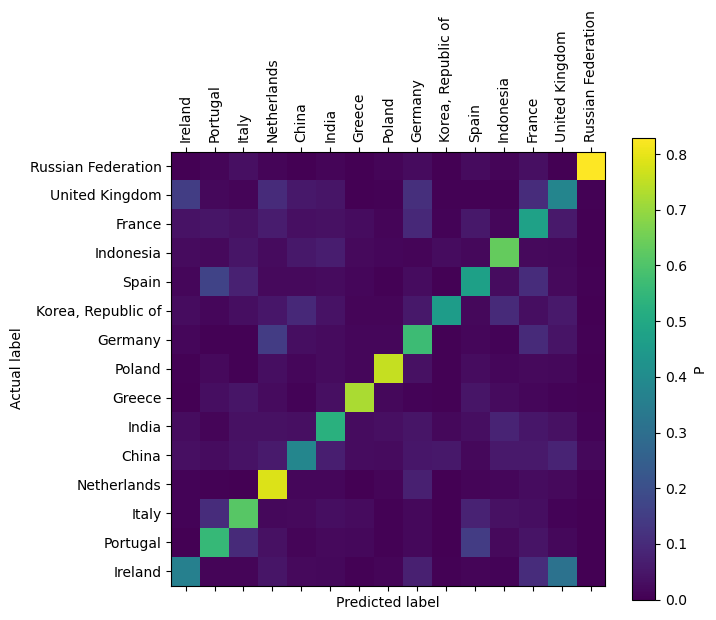

/var/folders/yl/dclvswrn4k967wl71rmbvx_r0000gq/T/ipykernel_37031/1177855880.py:25: RuntimeWarning: divide by zero encountered in log10
  Z_plot = np.log10(confusion_matrix)


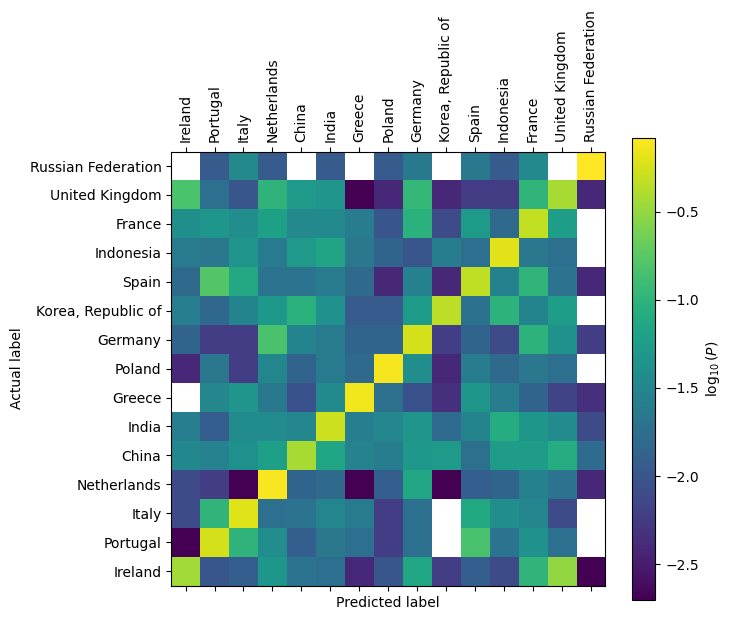

In [21]:
def evaluate_confusion_matrix(items,labels,
                              log_z=False,
                              plot=True,
                              return_confusion_matrix=True):
    #
    prediction_matrix = np.zeros([N_categories,N_categories],dtype=float)
    N_samples = np.zeros(N_categories,dtype=int)
    #
    for item, label in zip(items,labels):
        #
        # calculate predicted class
        _, predicted_label = model(item).topk(1)
        #
        prediction_matrix[label,predicted_label] += 1
        N_samples[label] += 1
    #
    confusion_matrix = prediction_matrix / N_samples[:,np.newaxis]
    #
    #
    # plot (code mostly from the tutorial )
    if plot:
        fig, ax = plt.subplots(1,1,figsize=(7,6))
        #
        if log_z:
            Z_plot = np.log10(confusion_matrix)
            zlabel = r'$\log_{10}(P)$'
        else:
            Z_plot = confusion_matrix
            zlabel = r'P'
        cax = ax.matshow(Z_plot)
        cbar = fig.colorbar(cax)

        # Set up axes
        ax.set_xticklabels([''] + list(categories.keys()), rotation=90)
        ax.set_yticklabels([''] + list(categories.keys()))

        # Force label at every tick
        ax.set_xticks(np.arange(N_categories+1)-1)
        ax.set_yticks(np.arange(N_categories+1)-1)

        ax.set_xlim([-0.5,N_categories-0.5])
        ax.set_ylim([-0.5,N_categories-0.5])

        #
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('Actual label')
        cbar.set_label(zlabel)

        plt.show()
        plt.close(fig)
    #
    if return_confusion_matrix:
        return confusion_matrix, N_samples
    else:
        return prediction_matrix, N_samples

#print("Confusion matrix for training data ({0} samples):".format(len(training_items)))
#prediction_matrix, N_samples = evaluate_confusion_matrix(training_items,training_labels)
#prediction_matrix, N_samples = evaluate_confusion_matrix(training_items,training_labels,
#                                                         log_z=True)

print("Confusion matrix for test data ({0} samples):".format(len(test_items)))
evaluate_confusion_matrix(test_items,test_labels)
confusion_matrix, N_samples = evaluate_confusion_matrix(test_items,test_labels,
                                                        log_z=True,
                                             return_confusion_matrix=True)

#print("Confusion matrix for training + test data ({0} samples):".format(len(training_items+test_items)))
#evaluate_confusion_matrix(training_items+ test_items,training_labels+test_labels)
#evaluate_confusion_matrix(training_items+ test_items,training_labels+test_labels,
#                          log_z=True);

The confusion matrix shows that the mostly misclassified names of the neural network are:

* Names from the UK being misclassified as Irish (and vice versa)
* Spanish names being misclassified as Portuguese

We here give the numerical values of the largest elements of the confusion matrix:

In [22]:
N_elements = 25

values, indices = torch.topk(input=torch.tensor(confusion_matrix.flatten()),
                             k=N_elements)
indices = np.array(np.unravel_index(indices=indices.numpy(),
                                    shape=np.shape(confusion_matrix))).T

output_string = '{label:20s} {prediction:20s} {relative_frequency:20s}'
print(output_string.format(label='label',
                      prediction='predicted label',
                      relative_frequency='relative frequency (~Probability)')
)
output_string = '{label:20s} {prediction:20s} {relative_frequency:3.3f}'
for index_pair in indices:
    #print(index_pair)
    print(output_string.format(
        label=list(categories.keys())[index_pair[0]], 
        prediction=list(categories.keys())[index_pair[1]],
        relative_frequency=confusion_matrix[index_pair[0],index_pair[1]])
          )

label                predicted label      relative frequency (~Probability)
Russian Federation   Russian Federation   0.830
Netherlands          Netherlands          0.786
Poland               Poland               0.758
Greece               Greece               0.724
Indonesia            Indonesia            0.634
Italy                Italy                0.614
Germany              Germany              0.568
Portugal             Portugal             0.556
India                India                0.525
France               France               0.476
Spain                Spain                0.470
Korea, Republic of   Korea, Republic of   0.460
China                China                0.380
United Kingdom       United Kingdom       0.378
Ireland              Ireland              0.360
Ireland              United Kingdom       0.312
Spain                Portugal             0.166
United Kingdom       Ireland              0.152
Germany              Netherlands          0.148
Portugal    